In [1]:
import os
import glob
import xarray as xr
import netCDF4 as nc
import numpy as np
from pyproj import Proj, Transformer, CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import math
import pandas as pd
import dask.array as da
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units
import rasterio
from shapely.geometry import Point
import geopandas as gpd

In [2]:
working_dir = '/Users/jacobqs/Documents/MST Himalaya/MST-Himalaya/'
home_dir = os.getenv("HOME")
# WFDE5 data
wfde5_path = home_dir + '/Documents/MST Himalaya/WFDE5/'
psurf_path = glob.glob(wfde5_path + 'psurf/*.nc')
qair_path = glob.glob(wfde5_path + 'qair/*.nc')
rainf_path = glob.glob(wfde5_path + 'rainf/*.nc')
snowf_path = glob.glob(wfde5_path + 'snowf/*.nc')
swdown_path = glob.glob(wfde5_path + 'swdown/*.nc')
tair_path = glob.glob(wfde5_path + 'tair/*.nc')
wind_path = glob.glob(wfde5_path + 'wind/*.nc')
cell_data_path = glob.glob(wfde5_path + 'cell_data/*.nc')
asurf_path = glob.glob(wfde5_path + 'asurf/*.nc')

# Discharge data
discharge_path = glob.glob(home_dir + '/Documents/MST Himalaya/discharge/*.txt')

# Testdata
test_path = working_dir + '/shyft_workspace/shyft-data/netcdf/orchestration-testdata/'
discharge_test_path = test_path + 'discharge.nc'
relhum_test_path = test_path + 'relative_humidity.nc'
precip_test_path = test_path + 'precipitation.nc'
swdown_test_path = test_path + 'radiation.nc'
temp_test_path = test_path + 'temperature.nc'
wind_test_path = test_path + 'wind_speed.nc'
cell_data_test_path = test_path + 'cell_data.nc'

In [3]:
# Datasets from the WDFE5 data
psurf = xr.open_mfdataset(psurf_path)
qair = xr.open_mfdataset(qair_path)
rainf = xr.open_mfdataset(rainf_path)
snowf = xr.open_mfdataset(snowf_path)
swdown = xr.open_mfdataset(swdown_path)
tair = xr.open_mfdataset(tair_path)
wind = xr.open_mfdataset(wind_path)
cell_data = xr.open_mfdataset(cell_data_path)
asurf = xr.open_mfdataset(asurf_path)

# Discharge dataset
discharge = pd.read_csv(discharge_path[0], header= 16)
discharge = discharge.rename(columns = {' 2015 ' : 'daily_flow'})
discharge.index = pd.to_datetime(discharge.index)
discharge_raw_ds = discharge.to_xarray()

# Datsets from nidelva data (on Shyft format)
discharge_test = xr.open_mfdataset(discharge_test_path)
relhum_test = xr.open_mfdataset(relhum_test_path)
precip_test = xr.open_mfdataset(precip_test_path)
swdown_test = xr.open_mfdataset(swdown_test_path)
temp_test = xr.open_mfdataset(temp_test_path)
wind_test = xr.open_mfdataset(wind_test_path)
cell_data_test = xr.open_mfdataset(cell_data_test_path)

In [4]:
x = cell_data.x.values
y = cell_data.y.values

catchment_id = cell_data.catchment_id.values

In [6]:
# Get lat and lon to extract from WFDE5

## Making a pyproj object for UTM Zone 45N

crs_32645 = CRS.from_epsg(32645) # CRS from cell_data file
crs_4326 = CRS.from_epsg(4326) # Lat-lon


## Create transformer to convert from CRS to CRS

transformer = Transformer.from_crs(crs_32645, crs_4326, always_xy = True)

lon, lat = transformer.transform(x, y)

lon.sort()
lat.sort()

In [7]:
# Min and max cooridnates to extract from

min_lon = lon.min()
print(f'Min lon: {min_lon}')
min_lat = lat.min()
print(f'Min lat: {min_lat}')
max_lon = lon.max()
print(f'Max lon: {max_lon}')
max_lat = lat.max()
print(f'Max lat: {max_lat}')

Min lon: 82.8860627875782
Min lat: 27.639464651636498
Max lon: 85.78765946343044
Max lat: 29.32421532572714


In [43]:
# Bounding box (coordinates rounded down to nearest values in WFDE5 and made such that the number of dimensions are the same)
min_lon = 82.75
min_lat = 25.75
max_lon = 88.25
max_lat = 31.25

In [44]:
# Get only data contained within these lat, lon coordinates
psurf_slice = psurf.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
wind_slice = wind.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
tair_slice = tair.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
rainf_slice = rainf.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
snowf_slice = snowf.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
qair_slice = qair.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
swdown_slice = swdown.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))
asurf_slice = asurf.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat))

In [49]:
# Scaling of variables

## Temperature
T_degc = tair_slice.Tair - 273.15
tair_slice = tair_slice.assign(Tair_degc= T_degc)

# Precipitation
Precip = rainf_slice.Rainf * 3600 + snowf_slice.Snowf * 3600
rainf_slice = rainf_slice.assign(Precip = Precip)

# Pressure
PSurf_hpa = psurf_slice.PSurf * 0.01
psurf_slice = psurf_slice.assign(PSurf_hpa = PSurf_hpa)





In [50]:
n = int(len(qair_slice.Qair) / 2)
tn_1 = qair_slice.isel(time = slice(0, n)).time.values
tn_2 = qair_slice.isel(time = slice(n, 2 * n)).time.values

In [51]:
rel_hum_1 = relative_humidity_from_specific_humidity(psurf_slice.PSurf_hpa.sel(time = tn_1).values * units.hPa, tair_slice.Tair_degc.sel(time = tn_1).values * units.degC, qair_slice.Qair.sel(time = tn_1).values).to('percent').magnitude

In [53]:
rel_hum_2 = relative_humidity_from_specific_humidity(psurf_slice.PSurf_hpa.sel(time = tn_2).values * units.hPa, tair_slice.Tair_degc.sel(time = tn_2).values * units.degC, qair_slice.Qair.sel(time = tn_2).values).to('percent').magnitude

In [54]:
rel_hum = np.append(rel_hum_1, rel_hum_2).reshape(2 * n, 12, 12)
rel_hum = rel_hum * 0.01

In [56]:

# Relative humidity

qair_slice = qair_slice.assign(relative_humidity = (['time', 'lon', 'lat'], rel_hum))

In [59]:
# Convert from lon, lat to x, y

# First we extract the longitudes and latitudes for the clusters 
# (variables have dimension ('time', 'clusters'))

lon_asurf = asurf_slice.lon.values
lat_asurf = asurf_slice.lat.values

In [65]:
# Need to now get elevation from a merged DEM from Central Himalaya obtained by the USGS Earth Explorer and using QGIS to merge the tiles

# First we need to stack asurf_slice

asurf_slice_stacked = asurf_slice.stack(station = ['lon', 'lat'])

In [72]:
# Making a list with a tuple of all (lon, lat) points

stations = asurf_slice_stacked.station.values

In [80]:
# Now we need to convert the list of tuples to a list of Point objects

points = []
for i in range(len(stations)):
    points.append(Point((stations[i][0], stations[i][1])))


In [81]:
# Make a GeoPandas dataframe with all the clusters and points
gdf = gpd.GeoDataFrame(np.arange(len(points)), geometry = points, crs = 4326)

In [82]:
# Make a list of all the points (lon, lat)
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]

In [2]:
# To get altitude DEM tiles from USGS are merged into one DEM using QGIS and CRS: 4326

## Opening this merged DEM

dem_dataset = rasterio.open('/Users/jacobqs/Documents/MST Himalaya/qgis/DEM/merged_DEM_central_himalaya.tif')

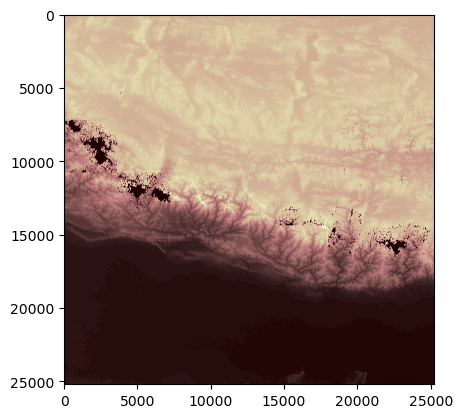

In [3]:
import matplotlib.pylab as plt
plt.imshow(dem_dataset.read(1), cmap='pink')
plt.show()

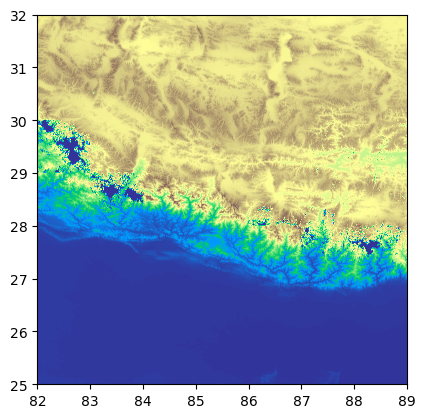

<AxesSubplot:>

In [5]:
from rasterio.plot import show
show(dem_dataset, cmap = 'terrain')

In [84]:
# Sample the coordinate points in coord_list in the DEM file
gdf['value'] = [x for x in dem_dataset.sample(coord_list)]

In [112]:
# Getting a list of all z values
z = []
for i in gdf['value'].values:
    z.append(i[0].astype('float64'))


In [113]:
# Now we stack also the forcing datasets to get stations

tair_slice_stacked = tair_slice.stack(station = ['lon', 'lat'])
wind_slice_stacked = wind_slice.stack(station = ['lon', 'lat'])
rainf_slice_stacked = rainf_slice.stack(station = ['lon', 'lat'])
qair_slice_stacked = qair_slice.stack(station = ['lon', 'lat'])
swdown_slice_stacked = swdown_slice.stack(station = ['lon', 'lat'])

In [114]:
## Making a pyproj object for UTM Zone 45N

lon_slice_stacked_asurf = asurf_slice_stacked.lon.values
lat_slice_stacked_asurf = asurf_slice_stacked.lat.values

crs_4326 = CRS.from_epsg(4326) # Lat-lon
crs_32645 = CRS.from_epsg(32645) # CRS 

## Create transformer to convert from CRS to CRS

transformer = Transformer.from_crs(crs_4326, crs_32645, always_xy = True)

x, y = transformer.transform(lon_slice_stacked_asurf, lat_slice_stacked_asurf)

In [117]:
ds_temperature = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(tair_slice_stacked.station))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        temperature = (['time', 'station'], tair_slice_stacked.Tair_degc.values.astype('float64'))
    ),
    coords = dict(
        time = (['time'], tair_slice_stacked.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

In [121]:
ds_precipitation = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(rainf_slice_stacked.station))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        precipitation = (['time', 'station'], rainf_slice_stacked.Precip.values.astype('float64'))
    ),
    coords = dict(
        time = (['time'], rainf_slice_stacked.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

In [122]:
ds_wind = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(wind_slice_stacked.station))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        wind_speed = (['time', 'station'], wind_slice_stacked.Wind.values.astype('float64'))
    ),
    coords = dict(
        time = (['time'], wind_slice_stacked.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

In [123]:
ds_rel_hum = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(qair_slice_stacked.station))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        relative_humidity = (['time', 'station'], qair_slice_stacked.relative_humidity.values.astype('float64'))
    ),
    coords = dict(
        time = (['time'], qair_slice_stacked.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

In [125]:
ds_radiation = xr.Dataset(
    data_vars = dict(
        series_name = (['station'], np.arange(len(swdown_slice_stacked.station))),
        crs = ((), np.array(-2147483647, dtype= 'int32')),
        global_radiation = (['time', 'station'], swdown_slice_stacked.SWdown.values.astype('float64'))
    ),
    coords = dict(
        time = (['time'], swdown_slice_stacked.time.values),
        x = (['station'], x),
        y = (['station'], y),
        z = (['station'], z)
    )  
)

In [147]:
# Now looking at discharge
discharge_raw_ds

<xarray.Dataset>
Dimensions:     (index: 5654)
Coordinates:
  * index       (index) datetime64[ns] 2000-01-01 2000-01-02 ... 2015-12-31
Data variables:
    daily_flow  (index) float64 39.1 39.1 38.5 38.5 38.3 ... 26.2 27.3 27.2 27.0

In [151]:
# Arughat discharge station coordinates

discharge_stations = {
    0 : {
        'name' : 'Arughat',
        'river' : 'Budhi Gandaki',
        'elevation' : 485,
        'start_date' : '1963-11-28',
        'latitude' : 28.04361,
        'longitude' : 84.81639,
        'x' : 285359.2540269664,
        'y' : 3103956.8282662127,
    }
}

In [152]:
discharge_series = np.array([1])
discharge_series = discharge_series.reshape(1,)
x_discharge = np.array(discharge_stations[0]['x'], dtype = 'float64').reshape((len(discharge_series), ))
y_discharge = np.array(discharge_stations[0]['y'], dtype = 'float64').reshape((len(discharge_series), ))
z_discharge = np.array(discharge_stations[0]['elevation'], dtype = 'float64').reshape((len(discharge_series), ))
x_discharge_da = da.from_array(x_discharge, chunks= len(discharge_series))
y_discharge_da = da.from_array(y_discharge, chunks = len(discharge_series))
z_discharge_da = da.from_array(z_discharge, chunks = len(discharge_series))

In [156]:
discharge_series = np.array([1])
daily_flow = discharge_raw_ds.daily_flow.values
daily_flow = np.reshape(daily_flow, (len(daily_flow), len(discharge_series)))
daily_flow = da.from_array(daily_flow, chunks = (len(discharge_raw_ds.index), (len(discharge_series))))
series_name = np.array([discharge_stations[0]['name']]).astype('object').reshape(len(discharge_series,))
series_name = da.from_array(series_name, chunks = (len(series_name),) )
discharge_crs = np.array([-2147483647]).astype('int32').reshape(())
catchment_id = np.array([10]).astype('int32').reshape(len(series_name,))
catchment_id = da.from_array(catchment_id)


In [157]:
disc_ds = xr.Dataset(
    data_vars = dict(
        series_name = (['series'], series_name),
        catchment_id = (['series'], catchment_id),
        crs =  discharge_crs,
        discharge = (['time', 'series'], daily_flow),
        
    ),
    coords = dict(
        time = discharge_raw_ds.index.values,
        x = (['series'],x_discharge_da),
        y = (['series'], y_discharge_da),
        z = (['series'], z_discharge_da)
    )
)

In [165]:
# WIND

ds_wind.x.attrs['axis'] = 'X'
ds_wind.x.attrs['standard_name'] = 'projection_x_coordinate'
ds_wind.x.attrs['units'] = 'm'

ds_wind.y.attrs['axis'] = 'Y'
ds_wind.y.attrs['standard_name'] = 'projection_y_coordinate'
ds_wind.y.attrs['units'] = 'm'

ds_wind.z.attrs['units'] = 'm'
ds_wind.z.attrs['standard_name'] = 'height'
ds_wind.z.attrs['axis'] = 'Z'
ds_wind.z.attrs['long_name'] = 'height above mean sea level'

ds_wind.series_name.attrs['cf_role'] = 'timeseries_id'

ds_wind.wind_speed.attrs['units'] = 'm s-1'
ds_wind.wind_speed.attrs['grid_mapping'] = 'crs'

ds_wind.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
ds_wind.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
ds_wind.crs.attrs['epsg_code'] = 'EPSG:32645'


# TEMPERATURE

ds_temperature.x.attrs['axis'] = 'X'
ds_temperature.x.attrs['standard_name'] = 'projection_x_coordinate'
ds_temperature.x.attrs['units'] = 'm'

ds_temperature.y.attrs['axis'] = 'Y'
ds_temperature.y.attrs['standard_name'] = 'projection_y_coordinate'
ds_temperature.y.attrs['units'] = 'm'

ds_temperature.z.attrs['units'] = 'm'
ds_temperature.z.attrs['standard_name'] = 'height'
ds_temperature.z.attrs['axis'] = 'Z'
ds_temperature.z.attrs['long_name'] = 'height above mean sea level'

ds_temperature.series_name.attrs['cf_role'] = 'timeseries_id'

ds_temperature.temperature.attrs['units'] = 'degC'
ds_temperature.temperature.attrs['grid_mapping'] = 'crs'

ds_temperature.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
ds_temperature.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
ds_temperature.crs.attrs['epsg_code'] = 'EPSG:32645'

# RADIATION

ds_radiation.x.attrs['axis'] = 'X'
ds_radiation.x.attrs['standard_name'] = 'projection_x_coordinate'
ds_radiation.x.attrs['units'] = 'm'

ds_radiation.y.attrs['axis'] = 'Y'
ds_radiation.y.attrs['standard_name'] = 'projection_y_coordinate'
ds_radiation.y.attrs['units'] = 'm'

ds_radiation.z.attrs['units'] = 'm'
ds_radiation.z.attrs['standard_name'] = 'height'
ds_radiation.z.attrs['axis'] = 'Z'
ds_radiation.z.attrs['long_name'] = 'height above mean sea level'

ds_radiation.series_name.attrs['cf_role'] = 'timeseries_id'

ds_radiation.global_radiation.attrs['units'] = 'W m-2'
ds_radiation.global_radiation.attrs['grid_mapping'] = 'crs'

ds_radiation.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
ds_radiation.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
ds_radiation.crs.attrs['epsg_code'] = 'EPSG:32645'

# RELATIVE HUMIDITY

ds_rel_hum.x.attrs['axis'] = 'X'
ds_rel_hum.x.attrs['standard_name'] = 'projection_x_coordinate'
ds_rel_hum.x.attrs['units'] = 'm'

ds_rel_hum.y.attrs['axis'] = 'Y'
ds_rel_hum.y.attrs['standard_name'] = 'projection_y_coordinate'
ds_rel_hum.y.attrs['units'] = 'm'

ds_rel_hum.z.attrs['units'] = 'm'
ds_rel_hum.z.attrs['standard_name'] = 'height'
ds_rel_hum.z.attrs['axis'] = 'Z'
ds_rel_hum.z.attrs['long_name'] = 'height above mean sea level'

ds_rel_hum.series_name.attrs['cf_role'] = 'timeseries_id'

ds_rel_hum.relative_humidity.attrs['units'] = '-'
ds_rel_hum.relative_humidity.attrs['grid_mapping'] = 'crs'

ds_rel_hum.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
ds_rel_hum.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
ds_rel_hum.crs.attrs['epsg_code'] = 'EPSG:32645'

# PRECIPITATION

ds_precipitation.x.attrs['axis'] = 'X'
ds_precipitation.x.attrs['standard_name'] = 'projection_x_coordinate'
ds_precipitation.x.attrs['units'] = 'm'

ds_precipitation.y.attrs['axis'] = 'Y'
ds_precipitation.y.attrs['standard_name'] = 'projection_y_coordinate'
ds_precipitation.y.attrs['units'] = 'm'

ds_precipitation.z.attrs['units'] = 'm'
ds_precipitation.z.attrs['standard_name'] = 'height'
ds_precipitation.z.attrs['axis'] = 'Z'
ds_precipitation.z.attrs['long_name'] = 'height above mean sea level'

ds_precipitation.series_name.attrs['cf_role'] = 'timeseries_id'

ds_precipitation.precipitation.attrs['units'] = 'mm h-1'
ds_precipitation.precipitation.attrs['grid_mapping'] = 'crs'

ds_precipitation.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
ds_precipitation.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
ds_precipitation.crs.attrs['epsg_code'] = 'EPSG:32645'

# DISCHARGE

disc_ds.x.attrs['axis'] = 'X'
disc_ds.x.attrs['standard_name'] = 'projection_x_coordinate'
disc_ds.x.attrs['units'] = 'm'

disc_ds.y.attrs['axis'] = 'Y'
disc_ds.y.attrs['standard_name'] = 'projection_y_coordinate'
disc_ds.y.attrs['units'] = 'm'

disc_ds.z.attrs['units'] = 'm'
disc_ds.z.attrs['standard_name'] = 'height'
disc_ds.z.attrs['axis'] = 'Z'
disc_ds.z.attrs['long_name'] = 'height above mean sea level'

disc_ds.series_name.attrs['cf_role'] = 'timeseries_id'

disc_ds.discharge.attrs['units'] = 'm3 s-1'
disc_ds.discharge.attrs['grid_mapping'] = 'crs'

disc_ds.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
disc_ds.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
disc_ds.crs.attrs['epsg_code'] = 'EPSG:32645'

In [166]:
# Checking values of datasets

## Checking for nans
t_bool = np.sum(ds_temperature.temperature.isnull().values)
r_bool = np.sum(ds_radiation.global_radiation.isnull().values)
rh_bool = np.sum(ds_rel_hum.relative_humidity.isnull().values)
w_bool = np.sum(ds_wind.wind_speed.isnull().values)
p_bool = np.sum(ds_precipitation.precipitation.isnull().values)
d_bool = np.sum(disc_ds.discharge.isnull().values)
print(t_bool)
print(r_bool)
print(rh_bool)
print(w_bool)
print(p_bool)
print(d_bool)

0
0
0
0
0
0


In [139]:
# Checking statistics
df_temp = ds_temperature.to_dataframe()
df_temp.describe()

,series_name,crs,temperature,x,y,z
count,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07
mean,7.150000e+01,-2.147484e+09,8.451238e+00,3.532234e+05,3.154746e+06,2.979764e+03
std,4.156822e+01,0.000000e+00,1.490074e+01,1.689370e+05,1.913135e+05,2.308373e+03
min,0.000000e+00,-2.147484e+09,-3.739259e+01,7.352859e+04,2.848022e+06,0.000000e+00
25%,3.575000e+01,-2.147484e+09,-3.114227e+00,2.157227e+05,3.002066e+06,1.052500e+02
50%,7.150000e+01,-2.147484e+09,7.370209e+00,3.539964e+05,3.156271e+06,4.426500e+03
75%,1.072500e+02,-2.147484e+09,2.157651e+01,4.880980e+05,3.310623e+06,4.955750e+03
max,1.430000e+02,-2.147484e+09,4.786276e+01,6.253669e+05,3.465107e+06,6.612000e+03


In [140]:
df_prec = ds_precipitation.to_dataframe()
df_prec.describe()

,series_name,crs,precipitation,x,y,z
count,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07
mean,7.150000e+01,-2.147484e+09,1.143892e-01,3.532234e+05,3.154746e+06,2.979764e+03
std,4.156822e+01,0.000000e+00,5.680852e-01,1.689370e+05,1.913135e+05,2.308373e+03
min,0.000000e+00,-2.147484e+09,0.000000e+00,7.352859e+04,2.848022e+06,0.000000e+00
25%,3.575000e+01,-2.147484e+09,0.000000e+00,2.157227e+05,3.002066e+06,1.052500e+02
50%,7.150000e+01,-2.147484e+09,0.000000e+00,3.539964e+05,3.156271e+06,4.426500e+03
75%,1.072500e+02,-2.147484e+09,0.000000e+00,4.880980e+05,3.310623e+06,4.955750e+03
max,1.430000e+02,-2.147484e+09,3.134995e+01,6.253669e+05,3.465107e+06,6.612000e+03


In [141]:
df_rel_hum = ds_rel_hum.to_dataframe()
df_rel_hum.describe()

,series_name,crs,relative_humidity,x,y,z
count,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07
mean,7.150000e+01,-2.147484e+09,6.261455e-01,3.532234e+05,3.154746e+06,2.979764e+03
std,4.156822e+01,0.000000e+00,2.467767e-01,1.689370e+05,1.913135e+05,2.308373e+03
min,0.000000e+00,-2.147484e+09,1.898075e-02,7.352859e+04,2.848022e+06,0.000000e+00
25%,3.575000e+01,-2.147484e+09,4.368637e-01,2.157227e+05,3.002066e+06,1.052500e+02
50%,7.150000e+01,-2.147484e+09,6.757985e-01,3.539964e+05,3.156271e+06,4.426500e+03
75%,1.072500e+02,-2.147484e+09,8.406493e-01,4.880980e+05,3.310623e+06,4.955750e+03
max,1.430000e+02,-2.147484e+09,1.004884e+00,6.253669e+05,3.465107e+06,6.612000e+03


In [142]:
df_rad = ds_radiation.to_dataframe()
df_rad.describe()

,series_name,crs,global_radiation,x,y,z
count,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07,3.786739e+07
mean,7.150000e+01,-2.147484e+09,2.286790e+02,3.532234e+05,3.154746e+06,2.979764e+03
std,4.156822e+01,0.000000e+00,3.065557e+02,1.689370e+05,1.913135e+05,2.308373e+03
min,0.000000e+00,-2.147484e+09,0.000000e+00,7.352859e+04,2.848022e+06,0.000000e+00
25%,3.575000e+01,-2.147484e+09,0.000000e+00,2.157227e+05,3.002066e+06,1.052500e+02
50%,7.150000e+01,-2.147484e+09,1.152440e+01,3.539964e+05,3.156271e+06,4.426500e+03
75%,1.072500e+02,-2.147484e+09,4.544658e+02,4.880980e+05,3.310623e+06,4.955750e+03
max,1.430000e+02,-2.147484e+09,1.199205e+03,6.253669e+05,3.465107e+06,6.612000e+03


In [143]:
df_wind = ds_wind.to_dataframe()
df_wind.describe()

,series_name,crs,wind_speed,x,y,z
count,2.272320e+07,2.272320e+07,2.272320e+07,2.272320e+07,2.272320e+07,2.272320e+07
mean,7.150000e+01,-2.147484e+09,2.136044e+00,3.532234e+05,3.154746e+06,2.979764e+03
std,4.156822e+01,0.000000e+00,1.459959e+00,1.689370e+05,1.913135e+05,2.308373e+03
min,0.000000e+00,-2.147484e+09,7.613546e-02,7.352859e+04,2.848022e+06,0.000000e+00
25%,3.575000e+01,-2.147484e+09,1.116769e+00,2.157227e+05,3.002066e+06,1.052500e+02
50%,7.150000e+01,-2.147484e+09,1.698999e+00,3.539964e+05,3.156271e+06,4.426500e+03
75%,1.072500e+02,-2.147484e+09,2.700285e+00,4.880980e+05,3.310623e+06,4.955750e+03
max,1.430000e+02,-2.147484e+09,1.399933e+01,6.253669e+05,3.465107e+06,6.612000e+03


In [167]:
df_disc = disc_ds.to_dataframe()
df_disc.describe()

,catchment_id,crs,discharge,x,y,z
count,5654.0,5.654000e+03,5654.000000,5.654000e+03,5.654000e+03,5654.0
mean,10.0,-2.147484e+09,158.606332,2.853593e+05,3.103957e+06,485.0
std,0.0,0.000000e+00,166.488569,5.821281e-11,0.000000e+00,0.0
min,10.0,-2.147484e+09,19.600000,2.853593e+05,3.103957e+06,485.0
25%,10.0,-2.147484e+09,35.900000,2.853593e+05,3.103957e+06,485.0
50%,10.0,-2.147484e+09,71.750000,2.853593e+05,3.103957e+06,485.0
75%,10.0,-2.147484e+09,258.750000,2.853593e+05,3.103957e+06,485.0
max,10.0,-2.147484e+09,906.000000,2.853593e+05,3.103957e+06,485.0


In [168]:
## Specify path where files are saved
home_dir = os.getenv('HOME')
output_folder = home_dir + '/Downloads'
output_wind = output_folder + '/wind_speed.nc'
output_rel_hum = output_folder + '/relative_humidity.nc'
output_temp = output_folder + '/temperature.nc'
output_radiation = output_folder + '/radiation.nc'
output_precipitation = output_folder + '/precipitation.nc'
output_discharge = output_folder + '/discharge.nc'

In [169]:
## Save netcdf files
# ds_wind.to_netcdf(path = output_wind, format = 'NETCDF4')
# ds_rel_hum.to_netcdf(path = output_rel_hum, format = 'NETCDF4')
# ds_temperature.to_netcdf(path = output_temp, format = 'NETCDF4')
# ds_radiation.to_netcdf(path = output_radiation, format = 'NETCDF4')
# ds_precipitation.to_netcdf(path = output_precipitation, format = 'NETCDF4')
disc_ds.to_netcdf(path = output_discharge, format = 'NETCDF4')

/Users/jacobqs/opt/miniconda3/envs/geohyd/lib/python3.10/site-packages/xarray/conventions.py:205: SerializationWarning: variable series_name has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


In [192]:
disc_ds

<xarray.Dataset>
Dimensions:       (series: 1, time: 5654)
Coordinates:
  * time          (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2015-12-31
    x             (series) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    y             (series) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    z             (series) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: series
Data variables:
    series_name   (series) object dask.array<chunksize=(1,), meta=np.ndarray>
    catchment_id  (series) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    crs           int32 -2147483647
    discharge     (time, series) float64 dask.array<chunksize=(5654, 1), meta=np.ndarray>

In [202]:
discharge_test.time.values

array(['2012-12-31T23:00:00.000000000', '2013-01-01T23:00:00.000000000',
       '2013-01-02T23:00:00.000000000', ...,
       '2015-12-29T23:00:00.000000000', '2015-12-30T23:00:00.000000000',
       '2015-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [205]:
d = xr.open_mfdataset(glob.glob('/Users/jacobqs/Downloads/BIDTUl89I5Fp3M6hBuH-8CawjcA__242/data/*.nc'))

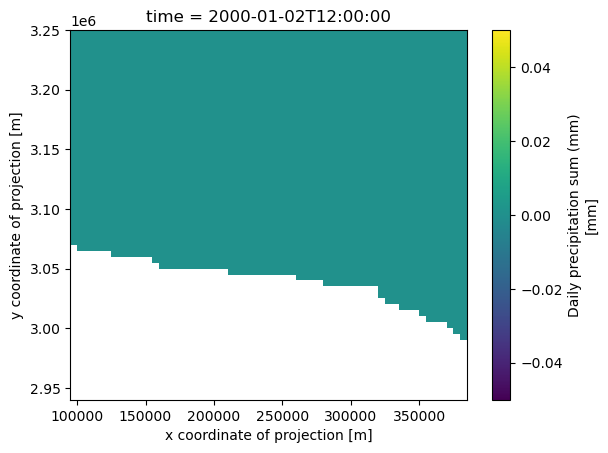

In [208]:
d.isel(time = 1).P.plot()


In [210]:
xc = cell_data.x.values
yc = cell_data.y.values
xd = d.x.values
yd = d.y.values

In [216]:
len(yd[:-4])

58

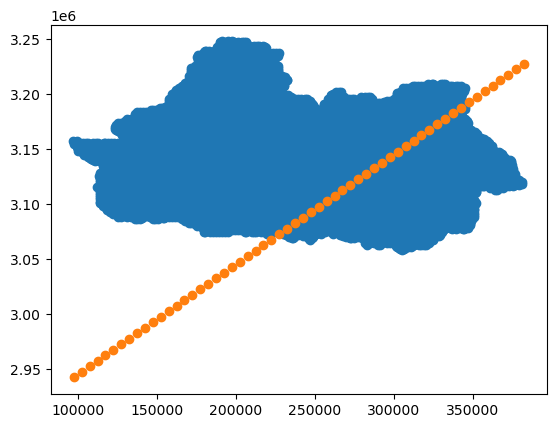

In [217]:
plt.scatter(xc,yc)
plt.scatter(xd,yd[:-4])

In [219]:
xc.min()

97121.29406171688

In [220]:
xc.max()

381013.5445878378

In [221]:
yd.min()

2942500.0

In [222]:
yd.max()

3247500.0